# Which Medical Conditions Cost the Most?

*Reese Petersen, 28 Sep 2021*

## Introduction

Why is healthcare so expensive? Many Americans may ask this question when looking for health insurance or seeing medical bills. While the answer to this question is complex and multi-faceted, we can make some progress in addressing healthcare costs by finding out which common conditions cost the most.

To be more specific, we can ask the question "In 2019, did Americans with the 5 most prevalent medical conditions spend significantly different amounts on average by condition?". Since the types of complications and treatments associated with different medical conditions can vary significantly I expect that there will be significant differences in the average expenditure per person by condition. There are also other, related questions worth exploring like "Which conditions do Americans spend the most on in total?" and "What conditions cost the most per person regardless of prevalence?".

The answers to these questions may be useful to policy-makers and consumers of medical services, since it will help them know what conditions to prevent to save money. These results may also be useful to insurance providers both to save money and to create useful policies.

## Data

### Data Source

   The United States Department of Health & Human Services directs the Agency for Healthcare Research and Quality, which conducts a Medical Expenditure Panel Survey (MEPS) every year. The most recent year availble is 2019. Therefore, the data files used in this analysis can be obtained from https://meps.ahrq.gov/mepsweb/data_stats/download_data_files.jsp by selecting Year: 2019 and checking Medical Conditions files, Household Component Event files, and Appendix to MEPS Event files, and then clicking "Search".

![meps.arhq.gov/mepsweb/data_stats/download_data_files.jsp](MepsDataSelection.png "Selected MEPS files")

I downloaded theses data files in .xlsx format, which I converted to .csv format with ssconvert. 

There is also a table of ICD10CDX medical conditions at https://meps.ahrq.gov/data_stats/download_data/pufs/h214/h214doc.pdf, which I converted to plain text with pdftotext, and then to a csv-similar format with regular expressions in Vim. 

To obtain the converted files directly you can also go to https://drive.google.com/drive/folders/1UAiIL0ZOH0pcc_Q-jqoolI4F0LkpyDFw?usp=sharing

The questionnaire sections and data collection process can be obtained from https://meps.ahrq.gov/mepsweb/survey_comp/survey.jsp.

### Data Analysis

Importing libraries:

In [1]:
import matplotlib.pyplot as plt # plotting
plt.rcParams['figure.figsize']=[12,8] # set figure size
import numpy as np # data management, analysis
import pandas as pd # data processing, plotting
import seaborn as sns # data plotting
from scipy import stats # data analysis
import itertools # calculating combinations
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # print all output from each cell
from rpy2.robjects.packages import importr # importing R packages

Loading csv data files:

In [2]:
med_cond_df = pd.read_csv('h214.csv')
clnk_df = pd.read_csv('h213if1.csv')
dental_visits_df = pd.read_csv('h213b.csv')
other_med_expns_df = pd.read_csv('h213c.csv')
hosp_inpatient_stays_df = pd.read_csv('h213d.csv')
emergnc_room_df = pd.read_csv('h213e.csv')
outpatient_visits_df = pd.read_csv('h213f.csv')
obmp_visits_df = pd.read_csv('h213g.csv')
home_health_df = pd.read_csv('h213h.csv')
presc_med_df = pd.read_csv('h213a.csv')
ICD10CDX_df = pd.read_csv('ICD10CDX_table.csv', delimiter=':')

Defining some useful functions:

In [3]:
def event_keep_columns(abbr):
    keepers = ['DUPERSID','EVNTIDX','LINKIDX',abbr+'XP19X'] # Each event dataframe has a different 2-letter prefix before XP19X for the total payments column label.
    return keepers # The prescribed medicines dataframe uses LINKIDX instead of EVNTIDX.

In [4]:
def reduce_event_df(df, abbr):
    all_keepers = event_keep_columns(abbr)
    these_keepers = [keeper for keeper in all_keepers if keeper in df.columns]
    res_df = df[these_keepers].rename(columns={abbr+'XP19X':'XP19X'}) # Rename the total payments column to prepare for concatenation.
    return res_df

Let's find the most common conditions.

In [5]:
ICD10CDX_df.sort_values(by='WEIGHTED BY perwt19f', ascending=False).head(10)

,ICD10CDX VALUE,ICD10CDX LABEL,UNWEIGHTED,WEIGHTED BY perwt19f
114,I10,ESSENTIAL (PRIMARY) HYPERTENSION,6010,61865446.44
0,-15,CANNOT BE COMPUTED,4748,54495002.23
53,E78,DISORD LIPOPROTEIN METAB AND OTH LIPIDEM,4317,44945040.79
67,F41,OTHER ANXIETY DISORDERS,2247,26195597.38
44,E11,TYPE 2 DIABETES MELLITUS,2547,25118443.17
218,M25,"OTHER JOINT DISORDER, NEC",2205,23684746.59
63,F32,"MAJ DEPRESSIVE DISORDER, SINGLE EPISODE",1944,21771623.43
155,J45,ASTHMA,1783,19120005.61
229,M54,DORSALGIA,1738,18844197.92
214,M19,OTHER AND UNSPECIFIED OSTEOARTHRITIS,1764,17897016.92


These results are weighted to be representative of the US population as a whole by the variable 'PERWT19F'. Details on how this weight is calculated can be found here:
https://meps.ahrq.gov/data_stats/download_data/pufs/h216/h216doc.pdf
starting on page 129.

It looks like the 5 most common conditions are hypertension, lipidemia, anxiety, type 2 diabetes, and joint disorders.
This raises the question of how to classify these medical conditions. I am going to stick to the ICD10CDX labels.
I note that at least 4 of these conditions are frequently associated with poor cardiovascular health, poor diet, and lack of exercise.

The number of people included in the 2019 survey is 28,512 and consists only of non-institutionalized civilians. To make population-level estimates, we only use the 27,648 people with non-zero statistical weight (PERWT19F).

Next, lets try to answer the main question at hand: In 2019, did Americans with the 5 most prevalent medical conditions spend significantly different amounts on average by condition?

The average expense per person can be estimated by joining the Event File tables, the CLNK table, and the Medical Conditions table.

![https://github.com/HHS-AHRQ/MEPS/blob/master/Quick_Reference_Guides/meps_erd.pdf](meps_erd.png "MEPS Entity Relationship Diagram")

First, I need to process the event dataframes (which contain expenses) into a single events dataframe:

In [6]:
dv_df = reduce_event_df(dental_visits_df, 'DV') # reduce_event_df keeps only the columns necessary for expense calculations + DUPERSID
om_df = reduce_event_df(other_med_expns_df, 'OM')
ip_df = reduce_event_df(hosp_inpatient_stays_df, 'IP')
er_df = reduce_event_df(emergnc_room_df, 'ER')
op_df = reduce_event_df(outpatient_visits_df, 'OP')
ob_df = reduce_event_df(obmp_visits_df, 'OB')
hh_df = reduce_event_df(home_health_df, 'HH')
rx_df = reduce_event_df(presc_med_df, 'RX') # All LINKIDX values are distinct from EVNTIDX values.

In [7]:
events_df = pd.concat([dv_df, om_df, ip_df, er_df, op_df, ob_df, hh_df, rx_df.rename(columns={'LINKIDX':'EVNTIDX'})], ignore_index=True)

This events dataframe now contains all events and each associated expense. The next step is to associate these events with medical conditions. The CLNK file is meant for this.

In [8]:
cond_event_df = pd.merge(med_cond_df[['DUPERSID','CONDIDX','ICD10CDX','PERWT19F']], clnk_df[['CONDIDX','EVNTIDX']], on='CONDIDX', how='left') # merge event ids to conditions
cond_expns_df = pd.merge(cond_event_df, events_df.drop(columns='DUPERSID'), how='left', on='EVNTIDX') # merge event expenses to conditions
cond_expns_posXP_df = cond_expns_df[(cond_expns_df['XP19X'] >= 0.0)] # keep condition-events with non-negative expense, negative values indicate missing information.
cond_expns_posXP_df.head(10)

,DUPERSID,CONDIDX,ICD10CDX,PERWT19F,EVNTIDX,XP19X
0,2320002103,2320002103001,Z00,19455.742319,2320002103200501,80.00
1,2320002103,2320002103001,Z00,19455.742319,2320002103200601,80.00
2,2320002103,2320002103001,Z00,19455.742319,2320002103200701,80.00
3,2320002103,2320002103001,Z00,19455.742319,2320002103200801,80.00
4,2320002103,2320002103002,R56,19455.742319,2320002103200101,364.76
5,2320002103,2320002103002,R56,19455.742319,2320002103200201,5447.51
6,2320002103,2320002103002,R56,19455.742319,2320002103200901,544.46
7,2320005101,2320005101001,-15,5919.292270,2320005101001403,16.80
8,2320005101,2320005101001,-15,5919.292270,2320005101001503,4.00
9,2320005102,2320005102001,I10,5356.640305,2320005102002403,1.79


The first person is associated with 7 events related to 2 conditions. The second person has a(n) unknown condition(s) associated with 2 events, and so on.

I need to sum the cost by person-condition, or by CONDIDX, discarding EVNTIDX and DUPERSID in the process, but not PERWT19F or ICD10CDX.

In [9]:
XPsum_by_CONDIDX_df = cond_expns_posXP_df.groupby(['CONDIDX','ICD10CDX','PERWT19F'], as_index=False)['XP19X'].sum()
XPsum_by_CONDIDX_df

,CONDIDX,ICD10CDX,PERWT19F,XP19X
0,2320002103001,Z00,19455.742319,320.00
1,2320002103002,R56,19455.742319,6356.73
2,2320005101001,-15,5919.292270,20.80
3,2320005102001,I10,5356.640305,7.16
4,2320005102004,Z13,5356.640305,2127.95
...,...,...,...,...
87426,2469687102007,K21,15756.362731,791.94
87427,2469687102009,M17,15756.362731,1119.64
87428,2469687102010,R11,15756.362731,387.03
87429,2469689101001,I10,8370.423095,888.52


The expense column includes payments made by all known payers, including individuals, public or private insurance.

I can compute the average cost per person by condition with the following formula:
$$ \frac{\sum_{i} w_i x_i}{\sum_{i} w_i} $$
where

$w_i =$ PERWT19F weight,

$x_i =$ XP19X total payment or expense,

and $i$ iterates over all the people with a single condition.

Fortunately, numpy can do a weighted average with the help of a lambda function and pandas groupby. I also need to make a dictionary to translate ICD10CDX values to labels.

In [10]:
records_ICD10CDX_dictionary_list = ICD10CDX_df[['ICD10CDX VALUE','ICD10CDX LABEL']].to_dict('records') # make a list of dictionaries
ICD10CDX_translation_dict = {subdict['ICD10CDX VALUE']:subdict['ICD10CDX LABEL'] for subdict in records_ICD10CDX_dictionary_list} # make a dictionary from the list of dictionaries

In [11]:
wm = lambda x: np.average(x, weights=XPsum_by_CONDIDX_df.loc[x.index, 'PERWT19F'])
avg_expns_by_cond_df = XPsum_by_CONDIDX_df.groupby('ICD10CDX').agg(average_expense=('XP19X',wm)).reset_index().replace(to_replace=ICD10CDX_translation_dict)
avg_expns_by_cond_df.head()

,ICD10CDX,average_expense
0,CANNOT BE COMPUTED,4124.318837
1,OTHER BACTERIAL INTESTINAL INFECTIONS,1497.150460
2,VIRAL AND OTHER SPECIFIED INTEST INFECT,774.040568
3,"INFECT GASTROENTERIT AND COLITIS, UNSPEC",1692.870861
4,OTHER SEPSIS,8650.366428


I have weighted average expense by condition. Last, I will merge this dataframe with the ICD10CDX dataframe and I can sort by weight.

In [12]:
ICD10CDX_df.rename(columns={'WEIGHTED BY perwt19f':'PERWT19F','ICD10CDX LABEL':'ICD10CDX'}, inplace=True)
avg_expns_by_cond_weighted_df = pd.merge(avg_expns_by_cond_df, ICD10CDX_df[['ICD10CDX','PERWT19F']], on='ICD10CDX', how='left')
avg_expns_by_cond_weighted_df.sort_values(by='PERWT19F', ascending=False).drop([0]).head()

,ICD10CDX,average_expense,PERWT19F
114,ESSENTIAL (PRIMARY) HYPERTENSION,784.678764,61865446.44
53,DISORD LIPOPROTEIN METAB AND OTH LIPIDEM,559.846829,44945040.79
67,OTHER ANXIETY DISORDERS,1320.988572,26195597.38
44,TYPE 2 DIABETES MELLITUS,4894.699121,25118443.17
218,"OTHER JOINT DISORDER, NEC",2082.778582,23684746.59


The average expense per person varies significantly by condition. We can look at the distributions next.

In [13]:
cond_expns_validICD_df = XPsum_by_CONDIDX_df[(~XPsum_by_CONDIDX_df['ICD10CDX'].isin(['-1','-7','-8','-15']))]
cond_expns_posXPWT_df = cond_expns_validICD_df[(cond_expns_validICD_df['PERWT19F'] > 0)]

In [14]:
hypertension_df = cond_expns_posXPWT_df[(cond_expns_posXPWT_df['ICD10CDX']=='I10')]
lipidemia_df = cond_expns_posXPWT_df[(cond_expns_posXPWT_df['ICD10CDX']=='E78')]
anxiety_df = cond_expns_posXPWT_df[(cond_expns_posXPWT_df['ICD10CDX']=='F41')]
diabetes_df = cond_expns_posXPWT_df[(cond_expns_posXPWT_df['ICD10CDX']=='E11')]
joint_df = cond_expns_posXPWT_df[(cond_expns_posXPWT_df['ICD10CDX']=='M25')]

In [15]:
top5_df = cond_expns_posXPWT_df[(cond_expns_posXPWT_df['ICD10CDX'].isin(['I10','E78','F41','E11','M25']))].replace(to_replace=ICD10CDX_translation_dict)

<AxesSubplot:xlabel='XP19X', ylabel='ICD10CDX'>

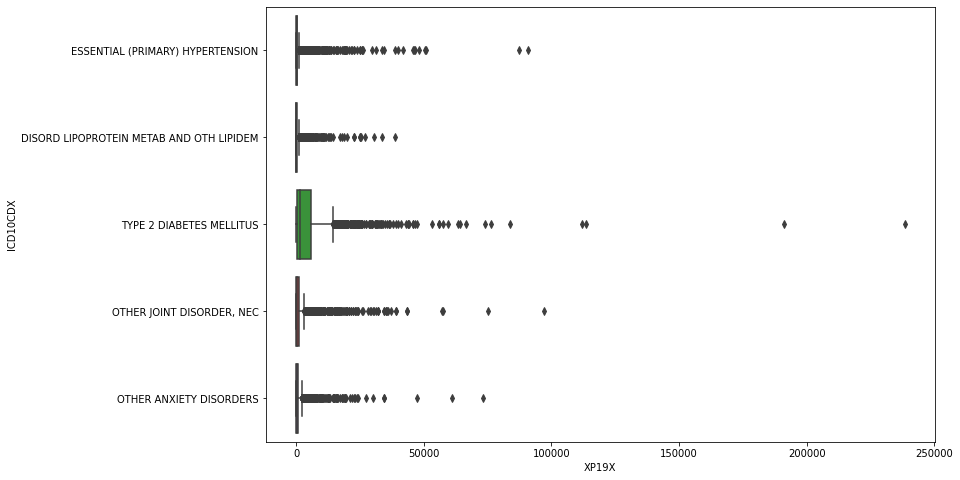

In [16]:
sns.boxplot(y='ICD10CDX', x='XP19X', data=top5_df, orient='h')

Let's zoom in on the x (expense) axis to see the primary distributions better.

<AxesSubplot:xlabel='XP19X', ylabel='ICD10CDX'>

(0.0, 15000.0)

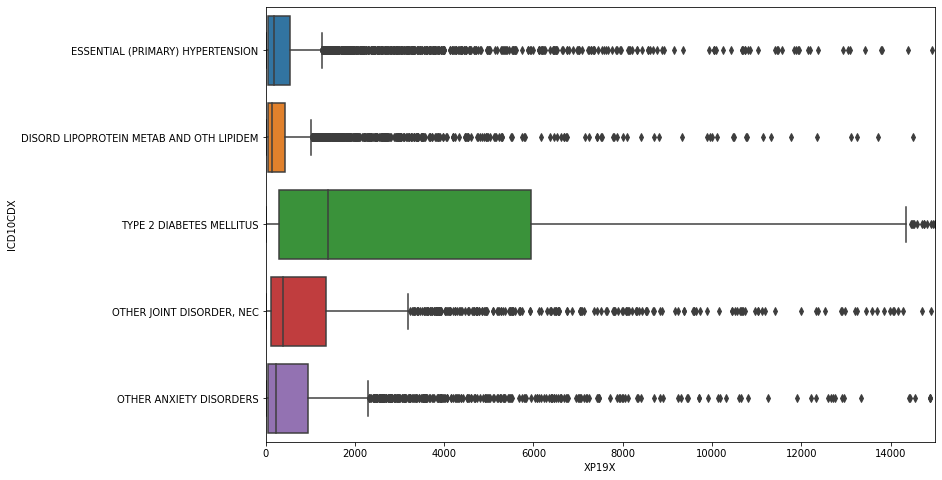

In [17]:
sns.boxplot(y='ICD10CDX', x='XP19X', data=top5_df, orient='h')
plt.xlim(0,15000)

These distributions look significantly different from each other. 

Diabetes costs much more on average than the other top 5 condition categories. I also note that for most of these conditions, most people are paying less than $400/year on average.

None of these distributions look normal. Next I plot a histogram for each one.

In [18]:
def plot_histogram(df):
    df['XP19X'].plot(kind='hist', weights=df['PERWT19F']) # plot a properly weighted histogram
    print('Skew: {}'.format(stats.skew(df['XP19X']))) # print skew, unweighted
    print('Kurtosis: {}'.format(stats.kurtosis(df['XP19X']))) # print kurtosis, unweighted

Skew: 13.817338769126264
Kurtosis: 277.26519509007534


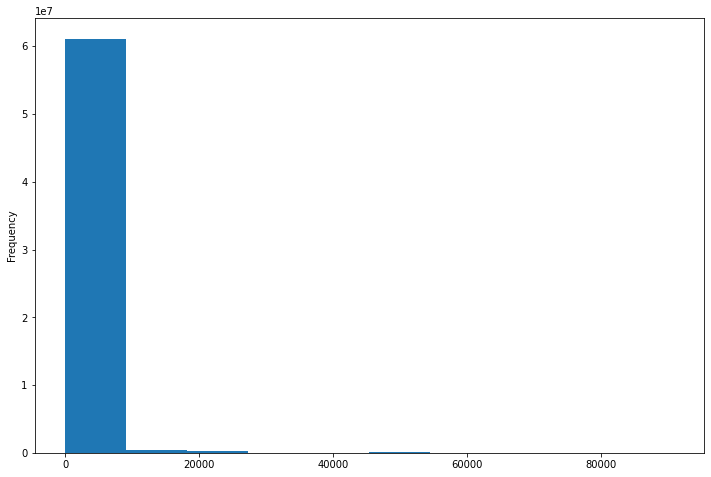

In [19]:
plot_histogram(hypertension_df)

Skew: 10.685992833709342
Kurtosis: 155.70329384428607


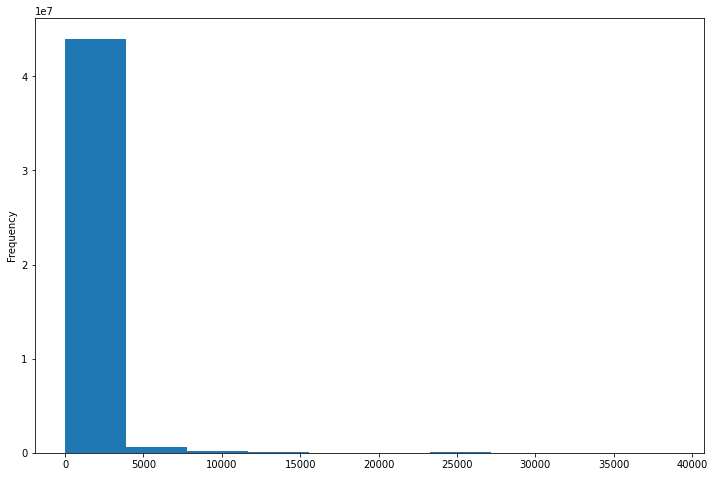

In [20]:
plot_histogram(lipidemia_df)

Skew: 8.83406907581681
Kurtosis: 120.79669891621238


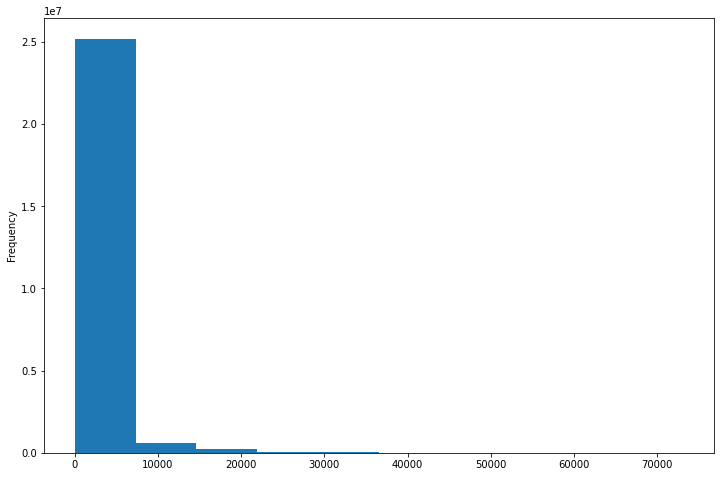

In [21]:
plot_histogram(anxiety_df)

Skew: 9.668822890871176
Kurtosis: 166.61890563954495


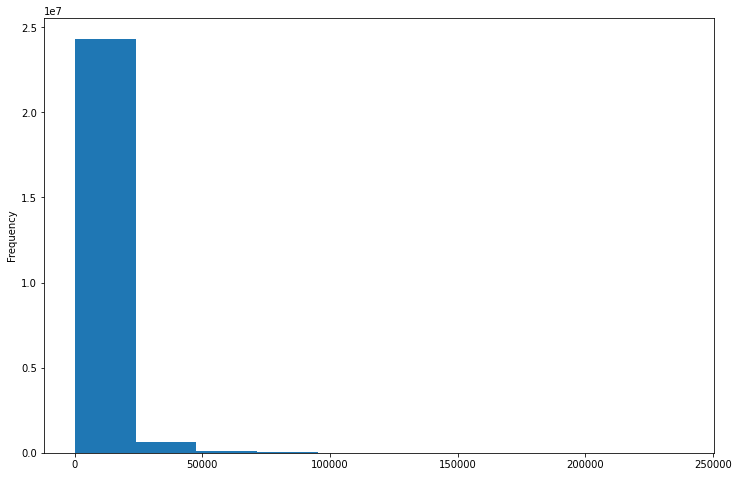

In [22]:
plot_histogram(diabetes_df)

Skew: 7.08909423136478
Kurtosis: 75.4820147407578


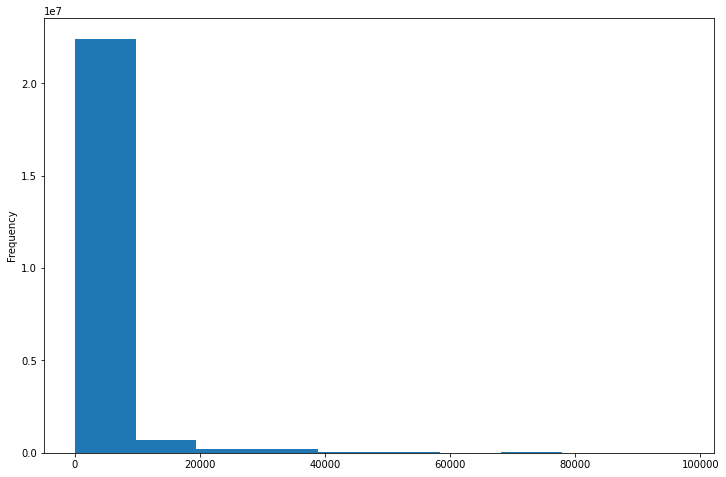

In [23]:
plot_histogram(joint_df)

The skew and kurtosis for each are extreme. Let's do a Kruskal-Wallis test on these 5 conditions to put a quantitative measure on how different they are.

In [24]:
top5_df['WEIGHTS'] = top5_df['PERWT19F'].astype(int)
top5_df.to_csv('top5.csv')

In [25]:
sjstats = importr('sjstats')
%load_ext rpy2.ipython

In [26]:
%%R
top5_rdf <- utils::read.csv('top5.csv', stringsAsFactors=FALSE)
sjstats::weighted_mannwhitney(XP19X ~ ICD10CDX + WEIGHTS, top5_rdf)


# Weighted Kruskal-Wallis test

  comparison of XP19X by ICD10CDX
  Chisq=4.00  df=1578  p-value=0.000



The Chisq or chi-square value is also called H, and is the Krusakl-Wallis test statistic.

The p-value is the probability of obtaining this statistic value or higher, assuming the groups all come from the same distribution. As we can see, the p-value is less than 0.001 and implies that it is very unlikely that this result occured by chance, which implies that at least one of the expense distributions is different from the others.

This essentially answers the primary question: In 2019, did Americans with the 5 most prevalent medical conditions spend significantly different amounts on average by condition?

Yes, yes they did. Also, don't get diabetes.

Next, I could try doing some pairwise tests to quantify which ones are the most or least different. In this case the pairwise non-parametric test of interest is the Mann-Whitney U test. It is very similar to the Kruskal-Wallis test just used.

In [27]:
%%R
hyp_lip <- subset(top5_rdf, ICD10CDX == "ESSENTIAL (PRIMARY) HYPERTENSION" | ICD10CDX == "DISORD LIPOPROTEIN METAB AND OTH LIPIDEM")
hyp_anx <- subset(top5_rdf, ICD10CDX == "ESSENTIAL (PRIMARY) HYPERTENSION" | ICD10CDX == "OTHER ANXIETY DISORDERS")
hyp_dia <- subset(top5_rdf, ICD10CDX == "ESSENTIAL (PRIMARY) HYPERTENSION" | ICD10CDX == "TYPE 2 DIABETES MELLITUS")
hyp_jnt <- subset(top5_rdf, ICD10CDX == "ESSENTIAL (PRIMARY) HYPERTENSION" | ICD10CDX == "OTHER JOINT DISORDER, NEC")
lip_anx <- subset(top5_rdf, ICD10CDX == "DISORD LIPOPROTEIN METAB AND OTH LIPIDEM" | ICD10CDX == "OTHER ANXIETY DISORDERS")
lip_dia <- subset(top5_rdf, ICD10CDX == "DISORD LIPOPROTEIN METAB AND OTH LIPIDEM" | ICD10CDX == "TYPE 2 DIABETES MELLITUS")
lip_jnt <- subset(top5_rdf, ICD10CDX == "DISORD LIPOPROTEIN METAB AND OTH LIPIDEM" | ICD10CDX == "OTHER JOINT DISORDER, NEC")
anx_dia <- subset(top5_rdf, ICD10CDX == "OTHER ANXIETY DISORDERS" | ICD10CDX == "TYPE 2 DIABETES MELLITUS")
anx_jnt <- subset(top5_rdf, ICD10CDX == "OTHER ANXIETY DISORDERS" | ICD10CDX == "OTHER JOINT DISORDER, NEC")
dia_jnt <- subset(top5_rdf, ICD10CDX == "TYPE 2 DIABETES MELLITUS" | ICD10CDX == "OTHER JOINT DISORDER, NEC")

In [28]:
%%R
# hypertension vs. lipidemia
sjstats::weighted_mannwhitney(XP19X ~ ICD10CDX + WEIGHTS, hyp_lip)


# Weighted Mann-Whitney-U test

  comparison of XP19X by ICD10CDX
  Chisq=3.01  df=10195  p-value=0.003



In [29]:
%%R
# hypertension vs. anxiety
sjstats::weighted_mannwhitney(XP19X ~ ICD10CDX + WEIGHTS, hyp_anx)


# Weighted Mann-Whitney-U test

  comparison of XP19X by ICD10CDX
  Chisq=5.82  df=8126  p-value=0.000



In [30]:
%%R
# hypertension vs. diabetes
sjstats::weighted_mannwhitney(XP19X ~ ICD10CDX + WEIGHTS, hyp_dia)


# Weighted Mann-Whitney-U test

  comparison of XP19X by ICD10CDX
  Chisq=34.95  df=8434  p-value=0.000



In [31]:
%%R
# hypertension vs. joint disorders
sjstats::weighted_mannwhitney(XP19X ~ ICD10CDX + WEIGHTS, hyp_jnt)


# Weighted Mann-Whitney-U test

  comparison of XP19X by ICD10CDX
  Chisq=15.21  df=8092  p-value=0.000



In [32]:
%%R
# lipidemia vs. anxiety
sjstats::weighted_mannwhitney(XP19X ~ ICD10CDX + WEIGHTS, lip_anx)


# Weighted Mann-Whitney-U test

  comparison of XP19X by ICD10CDX
  Chisq=7.47  df=6471  p-value=0.000



In [33]:
%%R
# lipidemia vs. diabetes
sjstats::weighted_mannwhitney(XP19X ~ ICD10CDX + WEIGHTS, lip_dia)


# Weighted Mann-Whitney-U test

  comparison of XP19X by ICD10CDX
  Chisq=35.97  df=6779  p-value=0.000



In [34]:
%%R
# lipidemia vs. joint disorders
sjstats::weighted_mannwhitney(XP19X ~ ICD10CDX + WEIGHTS, lip_jnt)


# Weighted Mann-Whitney-U test

  comparison of XP19X by ICD10CDX
  Chisq=17.00  df=6437  p-value=0.000



In [35]:
%%R
# anxiety vs. diabetes
sjstats::weighted_mannwhitney(XP19X ~ ICD10CDX + WEIGHTS, anx_dia)


# Weighted Mann-Whitney-U test

  comparison of XP19X by ICD10CDX
  Chisq=22.94  df=4710  p-value=0.000



In [36]:
%%R
# anxiety vs. joint disorders
sjstats::weighted_mannwhitney(XP19X ~ ICD10CDX + WEIGHTS, anx_jnt)


# Weighted Mann-Whitney-U test

  comparison of XP19X by ICD10CDX
  Chisq=6.61  df=4368  p-value=0.000



In [37]:
%%R
# diabetes vs. joint disorders
sjstats::weighted_mannwhitney(XP19X ~ ICD10CDX + WEIGHTS, dia_jnt)


# Weighted Mann-Whitney-U test

  comparison of XP19X by ICD10CDX
  Chisq=16.92  df=4676  p-value=0.000



All of the chi-square values are non-zero and the p-values are all less than 0.001 except for the hypertension-lipidemia comparison. Even for this comparison, the p-value is still rather small (0.003), so the probability that any of these condition cost distributions are actually the same is less than 1%.

Performing many pairwise comparison tests (Mann-Whitney) on a single dataset has a high risk of leading to a false positive when $1-(1-p)^{\frac{n(n-1)}{2}}$ is a significant probability, where $p$ is the p-value from the group test (Kruskal-Wallis) and $n$ is the number of groups. For this analysis the group test gave a very small p-value however, and indicated significant differences between groups, as did every pairwise test.

The largest differences are found when comparing the cost of diabetes to the others. It is the greatest outlier.

#### Bonus Questions

##### Most Expensive Conditions on Average

In [47]:
avg_expns_by_cond_df.sort_values(by='average_expense', ascending=False).head(5)

,ICD10CDX,average_expense
79,MULTIPLE SCLEROSIS,33993.951907
366,ASYMPTOMATIC HIV INFECTION STATUS,33256.910970
125,CEREBRAL INFARCTION,32580.931561
270,"DISOR OF NB SHRT GESTN, LOW BRTH WGT NEC",26877.752373
246,UNSPECIFIED KIDNEY FAILURE,24357.267572


These conditions are definitely less common, but they are not unheard-of. Let's see how many entries we actually have for each.

In [73]:
condition_counts_df = cond_expns_posXPWT_df.groupby(['ICD10CDX'], as_index=False).count().sort_values(by='CONDIDX',ascending=False).drop([0]).replace(to_replace=ICD10CDX_translation_dict)
condition_counts_df[(condition_counts_df['ICD10CDX'].isin(['MULTIPLE SCLEROSIS','ASYMPTOMATIC HIV INFECTION STATUS','CEREBRAL INFARCTION','DISOR OF NB SHRT GESTN, LOW BRTH WGT NEC','UNSPECIFIED KIDNEY FAILURE']))]

,ICD10CDX,CONDIDX,PERWT19F,XP19X
245,UNSPECIFIED KIDNEY FAILURE,86,86,86
78,MULTIPLE SCLEROSIS,72,72,72
124,CEREBRAL INFARCTION,54,54,54
365,ASYMPTOMATIC HIV INFECTION STATUS,37,37,37
269,"DISOR OF NB SHRT GESTN, LOW BRTH WGT NEC",21,21,21


Some of these counts are small enough, and the average expenses similar enough, that I do not think we can draw any strong conclusions about which conditions cost the most. There are, after all, many factors which can affect the cost, including particular complications, the tests and treaments chosen, and insurance.

#### Most Expensive Conditions in Total

In [46]:
XPsum_by_CONDIDX_posWT_df = XPsum_by_CONDIDX_df[(XPsum_by_CONDIDX_df['PERWT19F']>0)].copy()
XPsum_by_CONDIDX_posWT_df['total_weighted_expense'] = XPsum_by_CONDIDX_posWT_df['XP19X'] * XPsum_by_CONDIDX_posWT_df['PERWT19F']
XPsum_by_CONDIDX_posWT_df.groupby('ICD10CDX').agg('sum').reset_index().replace(to_replace=ICD10CDX_translation_dict).sort_values(by='total_weighted_expense', ascending=False).drop([0]).head(5)

,ICD10CDX,CONDIDX,PERWT19F,XP19X,total_weighted_expense
44,TYPE 2 DIABETES MELLITUS,6007010446329321,2.511844e+07,12187422.51,1.229472e+11
218,"OTHER JOINT DISORDER, NEC",5182372689971971,2.361059e+07,4303409.96,4.917564e+10
114,ESSENTIAL (PRIMARY) HYPERTENSION,14191316470699736,6.185377e+07,4837231.96,4.853534e+10
214,OTHER AND UNSPECIFIED OSTEOARTHRITIS,4145419367677399,1.784783e+07,3790060.64,4.158657e+10
117,CHRONIC ISCHEMIC HEART DISEASE,1916821969160793,8.101621e+06,3845328.57,3.687086e+10


Diabetes comes out on top, and the second and third conditions are not surprising either since they were in the top 5 most common conditions already. In fourth and fifth we have osteoarthritis, which is common in aging adults, and ischemic heart disease is closely related to the other common conditions. This largely confirms that Americans spend a great deal on the treatment of cardiovascular disease.

## Conclusion

### Actions

It may seem obvious that different medical conditions require different treatments and therefore have different average cost, but it is not obvious which conditions are the most expensive or why. In this analysis we find that diabetes is significantly more expensive on average than the other 4 most commmon medical conditions in the US in 2019. This could be because diabetes is frequently associated with multiple problematic symptoms and requires a regular supply to insulin to treat.

One conclusion for all audiences is that preventing diabetes saves significantly more money in medical costs per individual and in total than preventing the other common conditions analyzed here. Diabetes is linked to over-consumption of simple carbohydrates and lack of exercise. Many of the common pieces of medical advice for a healthy lifestyle apply to preventing diabetes.

Policy-makers might consider appropriate regulations on processed foods, especially those with high sugar content. It will also help to ensure that there are affordable supplies of insulin and metformin to those who are already affected.

Insurance companies and medical cost sharing programs could look for ways to encourage members to incorporate physical activity and low-carb foods into their lifestyles. 

### Biases

The medical conditions are self-reported, which may introduce some bias in the frequency and costs associated with each condition. This bias is difficult to test for however, as medical conditions do not always fit neatly into discrete categories and asking doctors to verify reported medical conditions would be time-consuming and costly. It is even possible that doctor-verified conditions could introduce a different kind of bias.

The data was collected with Computer Assisted Personal Interviewing (CAPI) technology, and one person from each household completed portions of the survey in multiple sessions. The survey participants are a subset of National Health Interview Survey participants. Since participation is voluntary and completed by one member of a household, this may introduce other kinds of bias which are difficult to properly measure. 

Obtaining comprehensive medical information involuntarily raises ethical issues, even if the data is anonymized, but it may be possible to compare survey results with other sources of data, like insurance companies and hospitals. In fact, the MEPS website provides Insurance/Employer and Medical Provider components which may help detect bias.

### Possibilities

The MEPS data set is extensive, and can be used to estimate the answers to many questions about healthcare in the US. Other variables that would interesting to study in future analyses include health insurance coverage, satisfaction with healthcare, demographic variables, and income.

## Appendix

### Lipidemia

The ICD10CDX label "DISORD LIPOPROTEIN METAB AND OTH LIPIDEM" took some effort to parse. Expanding the abbreviations gives: "Disorders Lipoprotein Metabolism and other Lipidemia", although I am guessing on "LIPIDEM". According to this article: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4860871/ disorders of lipid metabolism are very common and are associated with atheroscerlosis, which is the buildup of fatty plaque in the arteries. This increases the risk of strokes and heart attacks.

### Repeated expenses for medication

Are there cases where everything is the same except for ICD10CDX and CONDIDX?

A single eventid is associated with a single person, multiple conditions and at least two different expenses, but how do I distribute the expenses? Many, but not all of these, look like repeats. Why are they duplicated?

Let's go back to the consolidated event file.

In [38]:
events_df[(events_df['EVNTIDX'] == 2326898102014403)]

,DUPERSID,EVNTIDX,XP19X
375126,2326898102,2326898102014403,17.67
375127,2326898102,2326898102014403,17.67
375128,2326898102,2326898102014403,19.20
375129,2326898102,2326898102014403,19.20
375130,2326898102,2326898102014403,19.20
375131,2326898102,2326898102014403,19.20
375132,2326898102,2326898102014403,19.20
375133,2326898102,2326898102014403,19.20


This one, at least, appears to have duplicates from the prescribed medicines df. It is entirely possible to pay the same amount for several different drugs within the same event according to a friend in pharmacy school.
I will therefore not remove duplicates.